# Non-Contextual Image Segmentation

These set of techniques basically focus on applying a conditional criterion on an image which split the image into two or more segments. The criterion works on one or more global values obtained from the image.

## Simple Thresholding

Let's look at a simple grayscale image to understand how we can apply image thresholding to segment it.

In [63]:
# importing libraries

import cv2
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [165]:
# reading image using opencv
name = 'babatpur-1'
image = cv2.imread('..//assets//images//{}.jpg'.format(name))
print('Image matrix shape {}'.format(image.shape))

Image matrix shape (2048, 1365, 3)


In [166]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print('Image matrix shape {}'.format(image_g.shape))

Image matrix shape (2048, 1365)


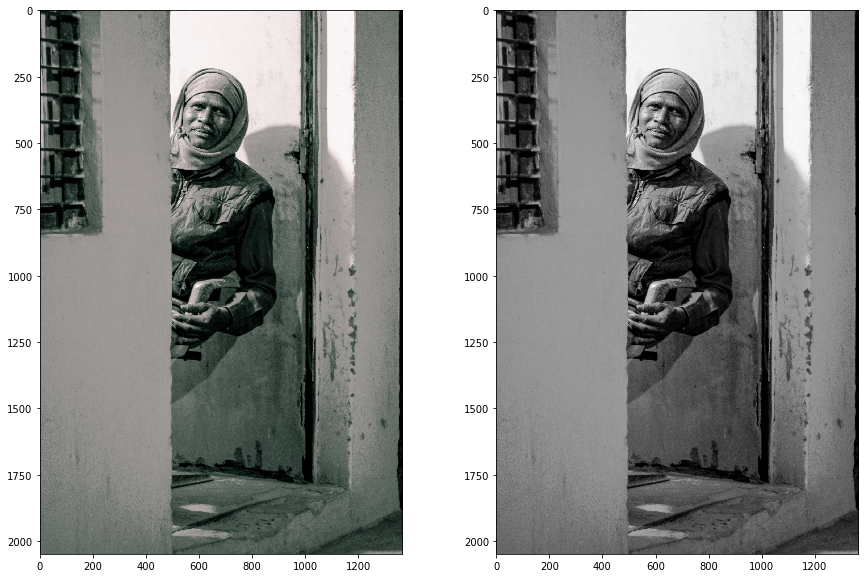

In [167]:
f, ax = plt.subplots(1, 2, figsize = (15, 10))
ax[0].imshow(image)
ax[1].imshow(image_g, cmap = 'gray')
plt.show()

In [168]:
# function to perform simple thresholding

def simple_thresholding1(img, thr):
    
    img_t = np.where(img >= thr, 255, 0)
    
    return img_t

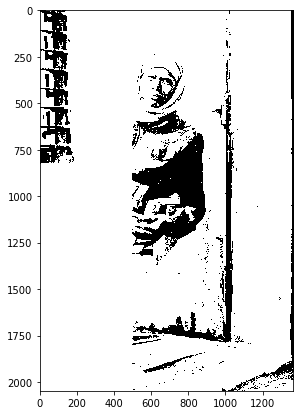

In [169]:
image_th1 = simple_thresholding1(image_g, 50)

f, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.imshow(image_th1, cmap = 'gray')
plt.show()

In [170]:
# function to print histogram of an image

def image_hist(img):
    
    if len(img.shape) == 3:
        f, ax = plt.subplots(1, 3, figsize = (20, 5))
        ax[0].plot(cv2.calcHist([img[:, :, 0]],[0],None,[256],[0,256]), color = 'red')
        ax[1].plot(cv2.calcHist([img[:, :, 0]],[0],None,[256],[0,256]), color = 'green')
        ax[2].plot(cv2.calcHist([img[:, :, 0]],[0],None,[256],[0,256]), color = 'blue')
        plt.show()
    else:
        f, ax = plt.subplots(1, 1, figsize = (20, 5))
        ax.plot(cv2.calcHist([img[:, :]],[0],None,[256],[0,256]), color = 'black')
        plt.show()

# function to perform simple thresholding operation with two threshold values

def simple_thresholding2(img, thr1, thr2):
    
    img_t = np.where(img >= thr2, 255, np.where(img >= thr1, 125, 0))
    
    return img_t

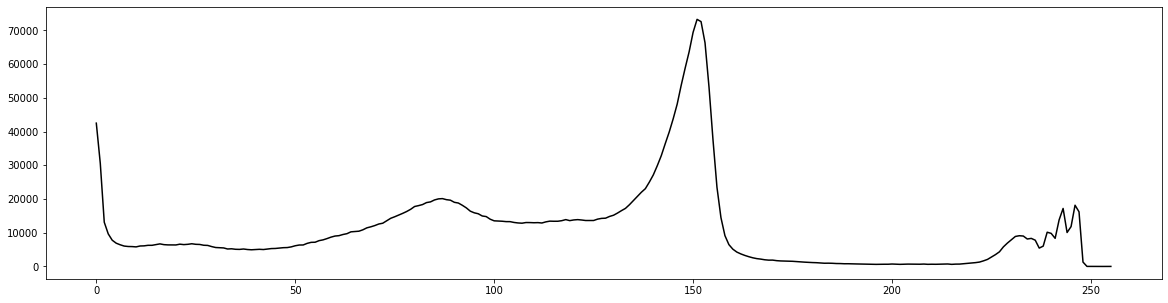

In [171]:
image_hist(image_g)

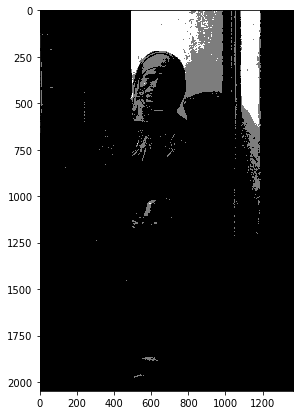

In [172]:
image_th1 = simple_thresholding2(image_g, 160, 235)
f, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.imshow(image_th1, cmap = 'gray')
plt.show()

In [173]:
from ipywidgets import interact, widgets

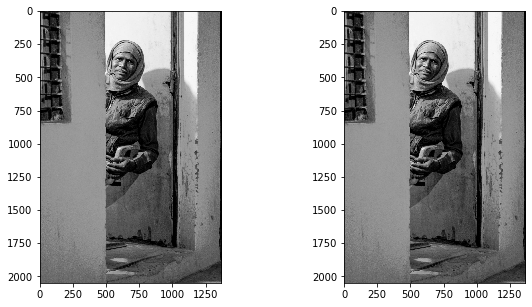

interactive(children=(IntSlider(value=1, description='threshold', max=250, step=2), Output()), _dom_classes=('…

In [174]:
def plot_thr(threshold):
    image_th1 = simple_thresholding1(image_g, threshold)
    ax[1].imshow(image_th1, cmap="gray")
    f.canvas.draw()
    display(f)

f, ax = plt.subplots(1, 2, figsize = (10, 5))

ax[0].imshow(image_g, cmap="gray")
ax[1].imshow(image_g, cmap="gray")

interact(plot_thr, threshold=widgets.IntSlider(min=0,max=250,step=2,value=1));

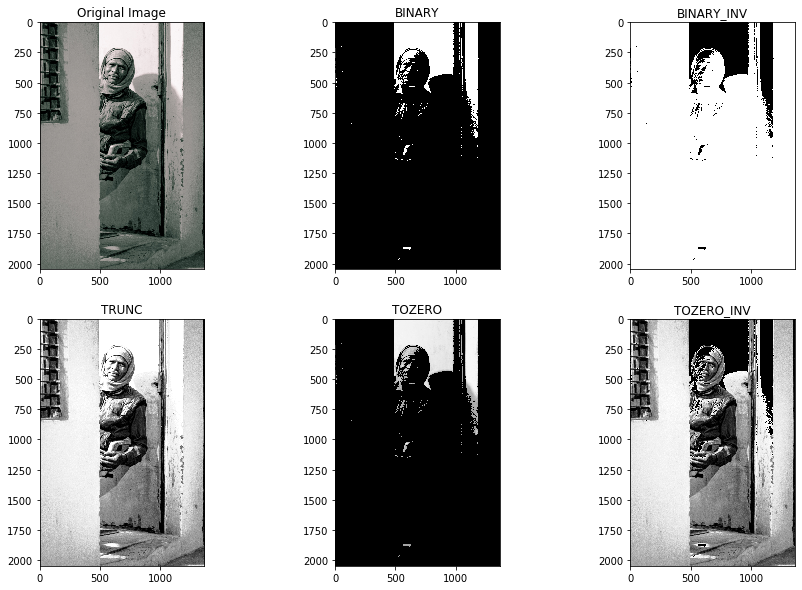

In [175]:
ret,thresh1 = cv2.threshold(image_g, 160, 235, cv2.THRESH_BINARY)
ret,thresh2 = cv2.threshold(image_g, 160, 235, cv2.THRESH_BINARY_INV)
ret,thresh3 = cv2.threshold(image_g, 160, 235, cv2.THRESH_TRUNC)
ret,thresh4 = cv2.threshold(image_g, 160, 235, cv2.THRESH_TOZERO)
ret,thresh5 = cv2.threshold(image_g, 160, 235, cv2.THRESH_TOZERO_INV)

titles = ['Original Image','BINARY','BINARY_INV','TRUNC','TOZERO','TOZERO_INV']
images = [image, thresh1, thresh2, thresh3, thresh4, thresh5]

f, ax = plt.subplots(2, 3, figsize = (15, 10))
for i in range(2):
    for j in range(3):
        ax[i][j].imshow(images[3*i+j],'gray')
        ax[i][j].set_title(titles[3*i+j])

plt.show()

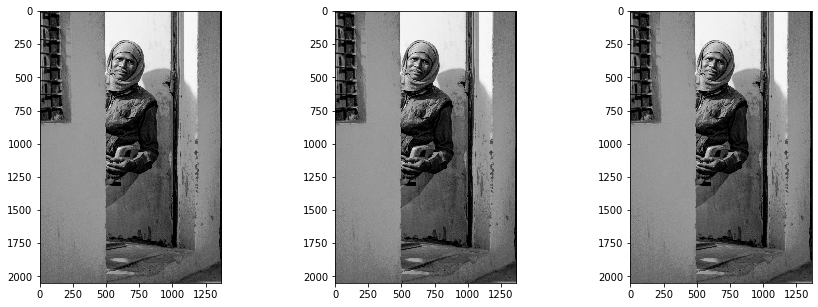

interactive(children=(IntSlider(value=11, description='size', max=1364, min=11, step=2), Output()), _dom_class…

In [176]:
def plot_thr(size):
    th2 = cv2.adaptiveThreshold(image_g,255,cv2.ADAPTIVE_THRESH_MEAN_C,\
            cv2.THRESH_BINARY,size,2)
    th3 = cv2.adaptiveThreshold(image_g,255,cv2.ADAPTIVE_THRESH_GAUSSIAN_C,\
            cv2.THRESH_BINARY,size,2)
    
    ax[1].imshow(th2, cmap="gray")
    ax[2].imshow(th3, cmap="gray")
    f.canvas.draw()
    display(f)

f, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].imshow(image_g, cmap="gray")
ax[1].imshow(image_g, cmap="gray")
ax[2].imshow(image_g, cmap="gray")

interact(plot_thr, size=widgets.IntSlider(min=11,max=min(image_g.shape[0], image_g.shape[1]) - 1,step=2,value=1));

# A More Analytical Method To Segment Image using Thresholding

We have seen that different values of threshold yield different results. Thus we need to find out that value of threshold which will yield the best result.

This brings up a point about how should we evaluate which segmented image is better. A criterion to evaluate the quality of segmented images is the __sum of class variances__.

_intra class variance = square of sum of (pixel intensity - mean pixel intensity of the class) / number of pixels in the class_

_sum of intra class variances = sum of (intra class variance) for each class_

Let's write some code to see if we can visualize what we have conceptualized.

## How Does Intra-Class Variance Vary for Different Thresholds

In [177]:
img_hist = cv2.calcHist([image_g], [0], None, [256], [0,256])

In [178]:
def class_variance(hist, lower, upper):
    
    class_data = hist[lower:upper]
    weight = sum(class_data)/sum(hist)
    intensities = np.arange(lower, upper)
    weighted_sum = class_data.T*intensities.T
    if sum(class_data) == 0:
        mu = 0
        sigma2 = 0
    else:
        mu = sum(weighted_sum[0])/sum(class_data)[0]
        deviations2 = (class_data - mu).T*(class_data - mu).T
        sigma2 = sum((deviations2*intensities.T)[0])/sum(class_data)[0]
    
    
    return mu, sigma2

sigmas = []
n = sum(img_hist)
for i in range(1, 255):
    _, s1 = class_variance(img_hist, 0, i)
    _, s2 = class_variance(img_hist, i, 256)
    sigma = sum(img_hist[0:i])*s1/n + sum(img_hist[i:256])*s2/n
    sigmas.append(sigma[0])

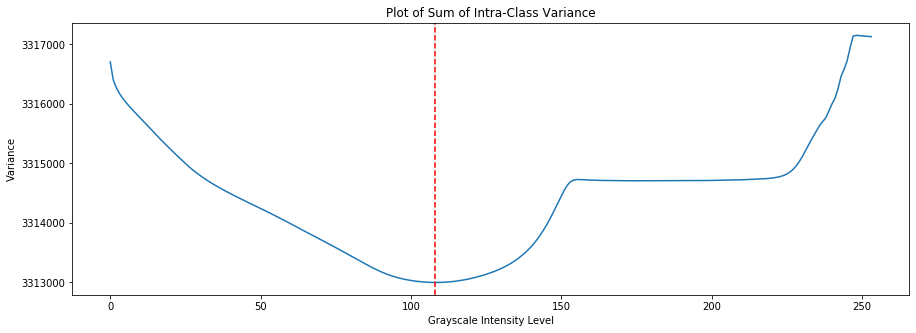

In [179]:
f, ax = plt.subplots(1, 1, figsize = (15, 5))
ax.plot(sigmas)
ax.axvline(x=np.argmin(sigmas), color='r', linestyle='--')
plt.title('Plot of Sum of Intra-Class Variance')
plt.xlabel('Grayscale Intensity Level')
plt.ylabel('Variance')
plt.show()

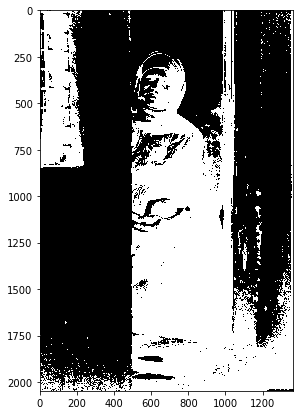

In [180]:
image_th = simple_thresholding1(image_g, np.argmin(sigmas))
image_th = 255 - image_th
f, ax = plt.subplots(1, 1, figsize = (7, 7))
plt.imshow(image_th, cmap = 'gray')
plt.show()

In [182]:
cv2.imwrite('{}_kmeans_seg.jpg'.format(name), image_th)

True

# What we have just discussed is called "Otsu's Method for Thresholding"

# Add Exercise for 3 class problem

## Let's Try Clustering

In [187]:
# reading image using opencv
name = 'bombay-1'
image = cv2.imread('..//assets//images//{}.jpg'.format(name))
print('Image matrix shape {}'.format(image.shape))

Image matrix shape (1080, 1080, 3)


In [188]:
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_g = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
print('Image matrix shape {}'.format(image_g.shape))

Image matrix shape (1080, 1080)


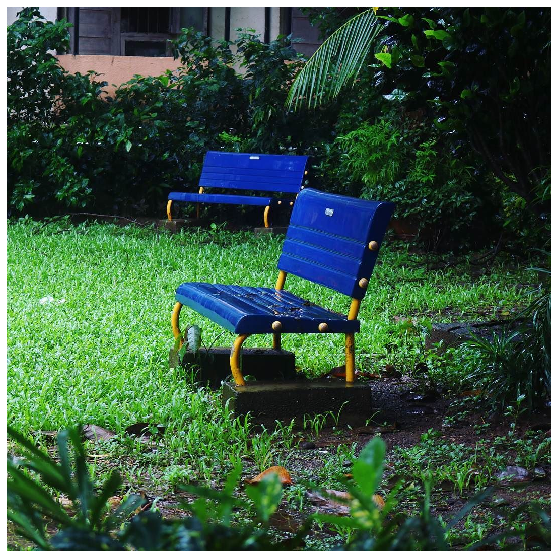

In [189]:
f, ax = plt.subplots(1, 1, figsize = (10, 10))
ax.imshow(image)
plt.axis('off')
plt.show()

In [191]:
import pandas as pd
from sklearn.cluster import KMeans

In [192]:
def cluster_image(img, k = 3):
    
    image_data = image.reshape(image.shape[0]*image.shape[1], image.shape[2])
    imdf = pd.DataFrame(data = image_data, columns = ['r', 'g', 'b'])
    
    kmeans = KMeans(k)
    kmeans.fit(imdf)
    
    imdf.loc[:, 'cluster'] = kmeans.labels_   
    
    clustermeans = pd.DataFrame(data = kmeans.cluster_centers_, columns = ['rc', 'gc', 'bc'])
    clustermeans.loc[:, 'cluster'] = clustermeans.index
    
    mergedf = imdf.merge(clustermeans, on = 'cluster', how = 'left')
    
    image_cl = mergedf[['rc', 'gc', 'bc']].values.reshape(image.shape[0], image.shape[1], image.shape[2])
    
    return image_cl

In [193]:
image_2 = cluster_image(image, k = 2)
image_3 = cluster_image(image, k = 3)
image_4 = cluster_image(image, k = 4)
image_5 = cluster_image(image, k = 5)
image_6 = cluster_image(image, k = 6)

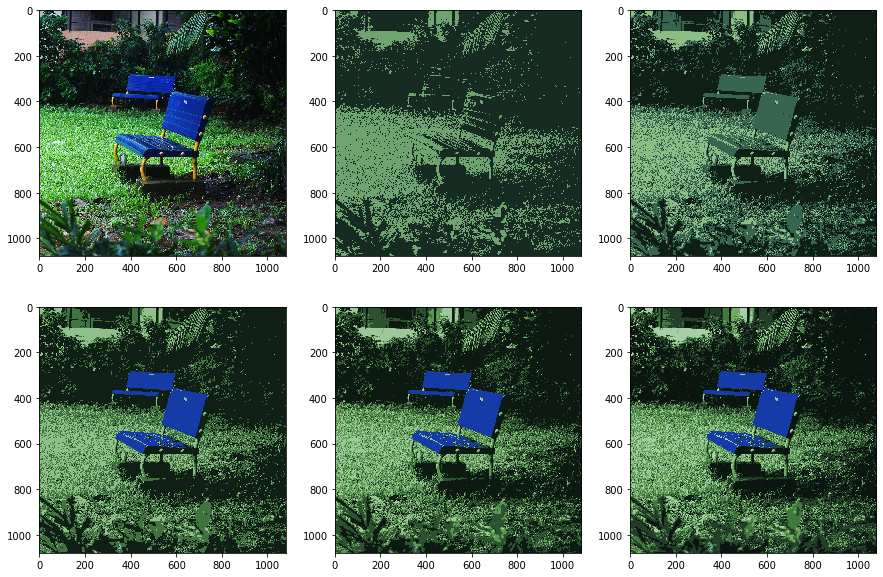

In [194]:
f, ax = plt.subplots(2, 3, figsize = (15, 10))
ax[0][0].imshow(image)
ax[0][1].imshow(image_2/255)
ax[0][2].imshow(image_3/255)
ax[1][0].imshow(image_4/255)
ax[1][1].imshow(image_5/255)
ax[1][2].imshow(image_6/255)
plt.show()

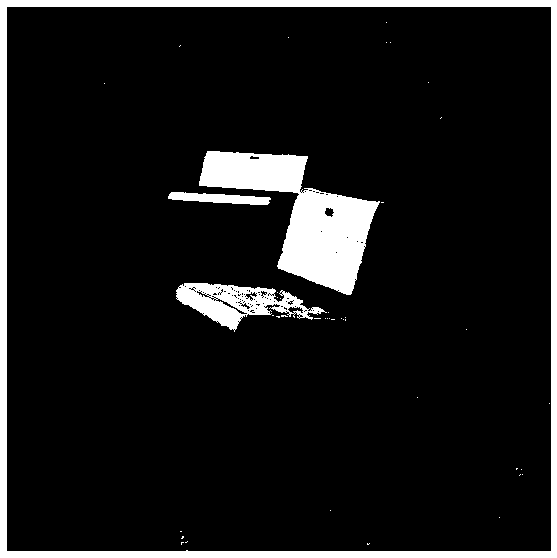

In [195]:
final = np.where((image_6[:, :, 2] > 150) & (image_6[:, :, 0] < 25), 255, 0)
f, ax = plt.subplots(1, 1, figsize = (10, 10))
plt.imshow(final, cmap = 'gray')
plt.axis('off')
plt.show()

It is worth noting that we can improve the output using morphological techniques which we learnt in the previous sessions

In [196]:
cv2.imwrite('bombay-1_kmeans_output.jpg', final)

True